## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [5]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Get proba

In [6]:
def get_proba(model):
    return np.exp((evol3G2M1S.get_aicc() - model.get_aicc())/2)

## Minimisation des modèles à mettre dans le _pandas_

In [7]:
########################################### Evol Simple

evol1G1M1S = stretchevol.Evol1G1M1S()
evol1G1M1S.set_data(df)

print('1G1M1S')

evol1G1M1S.minimize()

########################################### Evol Kessler

evol1G1M2S = stretchevol.Evol1G1M2S()
evol1G1M2S.set_data(df)

print('1G1M2S')

evol1G1M2S.minimize()

# evol1G1M2S.traceur()

########################################### Evol Howell

evol2G2M2S = stretchevol.Evol2G2M2S()
evol2G2M2S.set_data(df)

print('2G2M2S')

evol2G2M2S.minimize()
#evol2G2M2S.plotter()

########################################### Evol Howell Fixed

evol2G2M2SF = stretchevol.Evol2G2M2SF()
evol2G2M2SF.set_data(df)

print('2G2M2SF')

evol2G2M2SF.minimize()

########################################### Evol NR 1S

evol3G2M1S = stretchevol.Evol3G2M1S()
evol3G2M1S.set_data(df)

print('3G2M1S')

evol3G2M1S.minimize()

########################################### Evol NR 1S Fixed

evol3G2M1SF = stretchevol.Evol3G2M1SF()
evol3G2M1SF.set_data(df)

print('3G2M1SF')

evol3G2M1SF.minimize(limit_f = (0,1), limit_a = (0,1))

########################################### Evol NR 1S SNF

evol3G2M1SSNF = stretchevol.Evol3G2M1SSNF()
evol3G2M1SSNF.set_data(df[df['survey'] == 'SNF'])

evol3G2M1SSNF.minimize()

# evol3G2M1SSNF.plotter("3G2M1SSNF")

########################################### Evol NR 2S

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(df)

print('3G2M2S')

evol3G2M2S.minimize()

########################################### Evol NR 2S Fixed

evol3G2M2SF = stretchevol.Evol3G2M2SF()
evol3G2M2SF.set_data(df)

print('3G2M2SF')

evol3G2M2SF.minimize(limit_f = (0,1))

########################################### Evol NR 2S SNF

evol3G2M2SSNF = stretchevol.Evol3G2M2SSNF()
evol3G2M2SSNF.set_data(df[df['survey'] == 'SNF'])

print('3G2M2SSNF')

evol3G2M2SSNF.minimize()

# evol3G2M2SSNF.plotter()

########################################### Evol NR 3S

evol3G3M3S = stretchevol.Evol3G3M3S()
evol3G3M3S.set_data(df)

print('3G3M3S')

evol3G3M3S.minimize()

########################################### Evol NR 3S Fixed

evol3G3M3SF = stretchevol.Evol3G3M3SF()
evol3G3M3SF.set_data(df)

print('3G3M3SF')

evol3G3M3SF.minimize(limit_f = (0,1), limit_a = (0,1))
#evol3G3M3SF.migrad_out[0]

#fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/3G2M2SSNF.pdf', bbox_inches='tight')

1G1M1S
1G1M2S
2G2M2S
2G2M2SF
3G2M1S
3G2M1SF
3G2M2S
3G2M2SF
3G2M2SSNF
3G3M3S
3G3M3SF


## Comparison dataframe

In [8]:
modèles = [evol3G2M1S, evol3G2M2S, evol3G3M3S, evol2G2M2S,
           evol2G2M2SF, evol3G3M3SF, evol3G2M2SF,
           evol1G1M1S, evol3G2M1SF, evol1G1M2S]

d_mod_comp = pd.DataFrame({'Name': [k.__doc__ for k in modèles],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           'ln $\mathcal{L}$': [k.get_logl() for k in modèles],
                           'AICc': [k.get_aicc() for k in modèles],
                           '$\Delta$ AICc': [evol3G2M1S.get_aicc() - k.get_aicc() for k in modèles],
                           'Proba': [get_proba(k) for k in modèles]})

d_mod_comp

,Name,Fixed,Free param,ln $\mathcal{L}$,AICc,$\Delta$ AICc,Proba
0,Base$-(\sigma_2)$,False,4,1456.877645,1464.948567,0.000000,1.000000e+00
1,Base,False,5,1456.691574,1466.798146,-1.849578,3.966151e-01
2,"Base$+(\mu_1^{\mathrm{O}}, \sigma_1^{\mathrm{O...",False,7,1453.104388,1467.304031,-2.355464,3.079764e-01
3,Howell,False,4,1463.270251,1471.341173,-6.392605,4.091320e-02
4,Howell:$f$,True,5,1484.227341,1494.333913,-29.385346,4.159615e-07
5,"Base$+(\mu_1^{\mathrm{O}}, \sigma_1^{\mathrm{O...",True,8,1478.900015,1495.157158,-30.208590,2.756056e-07
6,Base:$f$,True,6,1484.227326,1496.376792,-31.428225,1.497779e-07
7,Gaussian,True,2,1521.810866,1525.832067,-60.883500,6.016113e-14
8,Base$-(\sigma_2):f$,True,5,1521.810883,1531.917455,-66.968888,2.870059e-15
9,Asymetric,True,3,1485.221282,1491.263760,-26.315192,1.930761e-06


In [33]:
path = '../Data/df_comparaison'
if cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

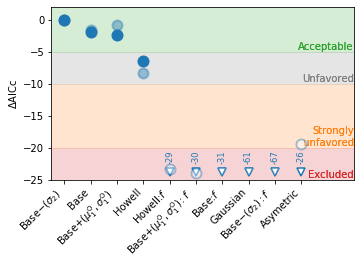

In [9]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 11

d_mod_comp_py = pd.read_csv('../Data/df_comparaison.dat')
d_mod_comp_cons = pd.read_csv('../Data/df_comparaison_cons.dat')

def show_results(data_, show_text=True, show_aicc=True, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AICc'
        ylow = -25
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
    prop_notfixed = dict(mfc="C0", mec="C0")
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    if not show_aicc:
        for i in [1,2,3,4,5]:
            cut = stats.norm.pdf(i, loc=0, scale=1)*2
            ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
            ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    else:
        spanprop = dict(alpha=.1, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Unfavored", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Strongly\n unfavored", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Excluded", color="tab:red", **textprop)
        
        if not show_aicc:
            ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC_c}}$)")
        else:
            ax.set_ylabel(r'$\Delta\mathrm{AICc}$')
    
    return(ylow)

ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../../Images/mod_comp.pdf', bbox_inches='tight')